In [10]:
import lb_scrapper as lbs
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
conn = sqlite3.connect('./datas/scrapped_lbc.db')
df = pd.read_sql_query("select * from Lyon_rent;", conn)
df.columns.tolist()

['link',
 'title',
 'price',
 'city',
 'nb_rooms',
 'surface',
 'charges',
 'furnished',
 'description',
 'update_date']

In [3]:
df.city=pd.Categorical(df.city, categories=sorted(df.city.unique().tolist()),ordered=True)

In [12]:
df.describe()

,price,nb_rooms,surface
count,500.000000,500.000000,500.000000
mean,938.948000,3.150000,65.048000
std,201.238802,0.362992,21.379988
min,583.000000,3.000000,1.000000
25%,799.000000,3.000000,58.000000
50%,891.000000,3.000000,66.000000
75%,1037.500000,3.000000,77.000000
max,1500.000000,5.000000,115.000000


A lot of observation with surface == 1 appears, which seems to be a wrong value, so we are going to delete them.

In [5]:
df.loc[df.surface == 1,"surface"] = None

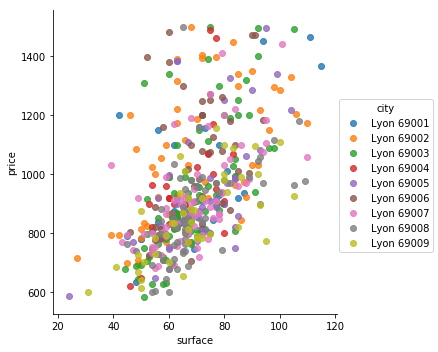

In [6]:
sns.lmplot(y="price",x='surface', hue="city",data=df,fit_reg=False)
plt.show()

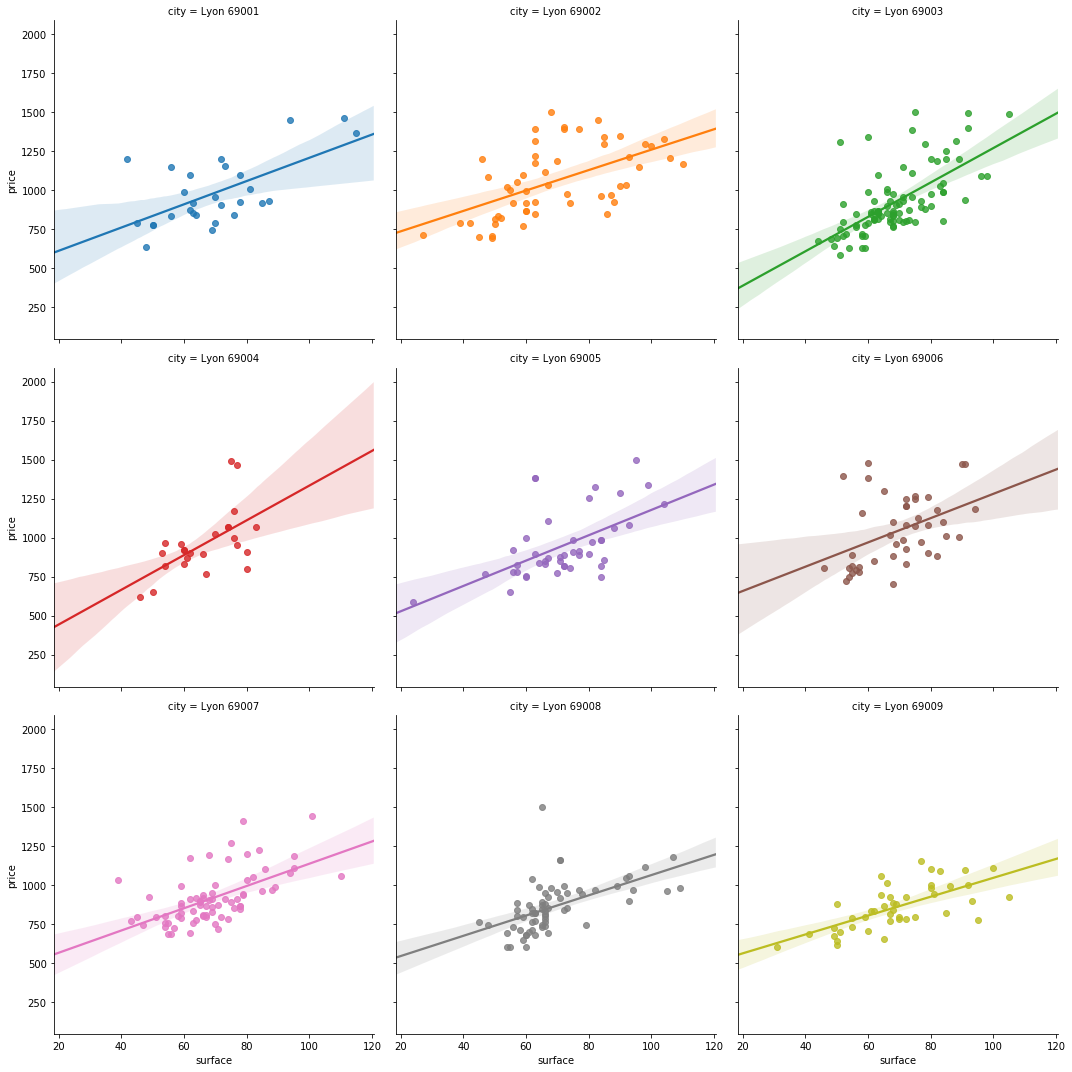

In [7]:
sns.lmplot(y="price",x='surface', hue="city", col="city",data=df,col_wrap=3)
plt.show()

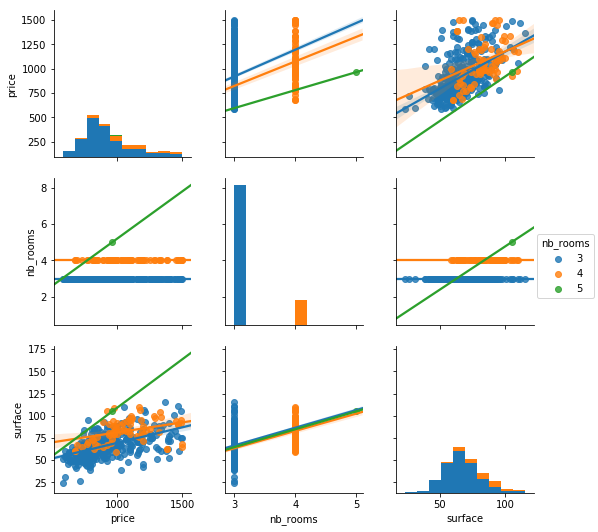

In [8]:
sns.pairplot(df.dropna(), kind="reg",hue="nb_rooms")
plt.show()